# **Observational Hertzsprung-Russell diagrams**
Auther : Amirmohammad Chegeni

[GitHub](https://github.com/AM-Chegeni)

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery

     |████████████████████████████████| 4.4 MB 24.5 MB/s 
     |████████████████████████████████| 802 kB 47.0 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 3.5 MB 37.7 MB/s 
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=6ead35591cdc2791cce1d7b590bce55d27d6ce9e80e7adb12eac9c01e2f59968
  Stored in directory: /root/.cache/pip/wheels/49/b4/2d/0081759ae1833bd694024801f7aacddcda8a687e8d5fbaeebd
Successfully built mimeparse


In [2]:
# import libraries

from astroquery.gaia import Gaia
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math
import seaborn as sns
import numpy as np
from astropy import log
from astroquery.utils.tap.core import TapPlus
from astroquery.utils.tap.core import Tap
import numpy as np
from matplotlib import cm
from matplotlib import colors
%matplotlib inline

print("libraries successfully imported")

libraries successfully imported


# Query

**This is a query to collect Gaia data. You can control the query size, columns and filters in data.**

In [ ]:
query = """SELECT 
  TOP 95000
  source_id, ra, dec, parallax, visibility_periods_used, astrometric_excess_noise, parallax_over_error, phot_g_mean_flux_over_error,
  phot_rp_mean_flux_over_error, phot_bp_mean_flux_over_error, phot_bp_rp_excess_factor, phot_bp_mean_mag, phot_rp_mean_mag, 
  astrometric_chi2_al, astrometric_n_good_obs_al, phot_g_mean_mag, bp_rp, e_bp_min_rp_val
  FROM gaiadr2.gaia_source
  where parallax_over_error > 10
  and visibility_periods_used > 8
  and phot_g_mean_flux_over_error > 50
  and phot_bp_mean_flux_over_error > 20
  and phot_rp_mean_flux_over_error > 20
  and phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
  and phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
  and astrometric_chi2_al/(astrometric_n_good_obs_al-5) < 1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
  """
  # and 1000/parallax <= {} ------> Sends an archive query for d < 200 pc

In [ ]:
# A function to collect data and convert it to DataFrame

def data_provider():
  tables = Gaia.load_tables(only_names=True)
  meta = Gaia.load_table('gaiadr2.gaia_source')
  job = Gaia.launch_job(query)
  results = job.get_results()
  results= np.array(results)
  results = pd.DataFrame(results)
  return results

In [ ]:
data = data_provider()
data

print('Data is ready (:')

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
Retrieving table 'gaiadr2.gaia_source'
Data is ready (:


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   source_id                     95000 non-null  int64  
 1   ra                            95000 non-null  float64
 2   dec                           95000 non-null  float64
 3   parallax                      95000 non-null  float64
 4   visibility_periods_used       95000 non-null  int16  
 5   astrometric_excess_noise      95000 non-null  float64
 6   parallax_over_error           95000 non-null  float32
 7   phot_g_mean_flux_over_error   95000 non-null  float32
 8   phot_rp_mean_flux_over_error  95000 non-null  float32
 9   phot_bp_mean_flux_over_error  95000 non-null  float32
 10  phot_bp_rp_excess_factor      95000 non-null  float32
 11  phot_bp_mean_mag              95000 non-null  float32
 12  phot_rp_mean_mag              95000 non-null  float32
 13  a

In [ ]:
g_abs = data['phot_g_mean_mag']+ 5 + 5*np.log10(data['parallax']/100)
data = pd.concat([data,g_abs],axis = 1)
data.rename(index=str,columns={0:'g_abs'},inplace=True)
data


,source_id,ra,dec,parallax,visibility_periods_used,astrometric_excess_noise,parallax_over_error,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_rp_excess_factor,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,phot_g_mean_mag,bp_rp,e_bp_min_rp_val,g_abs
0,6059850348176494592,192.374727,-58.592073,0.229744,17,0.000000,10.000001,4718.092773,1819.263062,603.133850,1.331245,14.783535,12.917463,301.550018,351,13.862558,1.866072,0.5210,5.668782
1,5786818418133769600,218.438884,-76.535295,0.709305,18,0.000000,10.000001,1528.336304,312.935913,143.786194,1.248929,17.652416,16.389519,233.028152,267,17.090054,1.262897,NaN,11.344218
2,1981106205636232832,328.788282,52.064269,0.473773,15,0.308551,10.000001,2967.798340,1101.345215,797.091980,1.222034,14.663825,13.794124,880.875793,235,14.316803,0.869701,NaN,7.694654
3,3115770487149358336,104.615488,2.601685,0.841241,11,0.000000,10.000001,1046.500977,98.081230,126.778633,1.291889,17.492434,15.957609,130.571075,139,16.782425,1.534824,0.4620,11.407026
4,5207893591545871488,109.034815,-80.543774,0.476303,18,0.000000,10.000001,1594.726929,302.698425,174.523254,1.264612,17.168371,15.860909,209.555847,222,16.590370,1.307463,0.6095,9.979787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94995,6734723094859922560,279.440990,-34.556999,0.485732,10,0.000000,10.014932,2480.106934,389.873993,307.232758,1.223060,15.309532,14.326775,131.178909,145,14.898198,0.982758,NaN,8.330181
94996,5599288463683203456,115.191036,-30.009973,0.211641,14,0.000000,10.014932,5147.987793,1316.149414,505.520721,1.303213,14.352630,12.660225,185.101761,241,13.538689,1.692405,0.3353,5.166685
94997,2181745671578410752,306.969893,52.647659,0.778280,16,0.000000,10.014932,963.619141,165.373383,65.994949,1.293323,18.126598,16.581091,189.663223,200,17.410254,1.545507,NaN,11.865934
94998,6070409778630633472,204.932030,-50.068231,0.779856,10,0.000000,10.014932,1538.935303,373.524841,348.747772,1.250278,16.529173,15.312106,165.177353,183,15.997563,1.217067,0.4193,10.457635


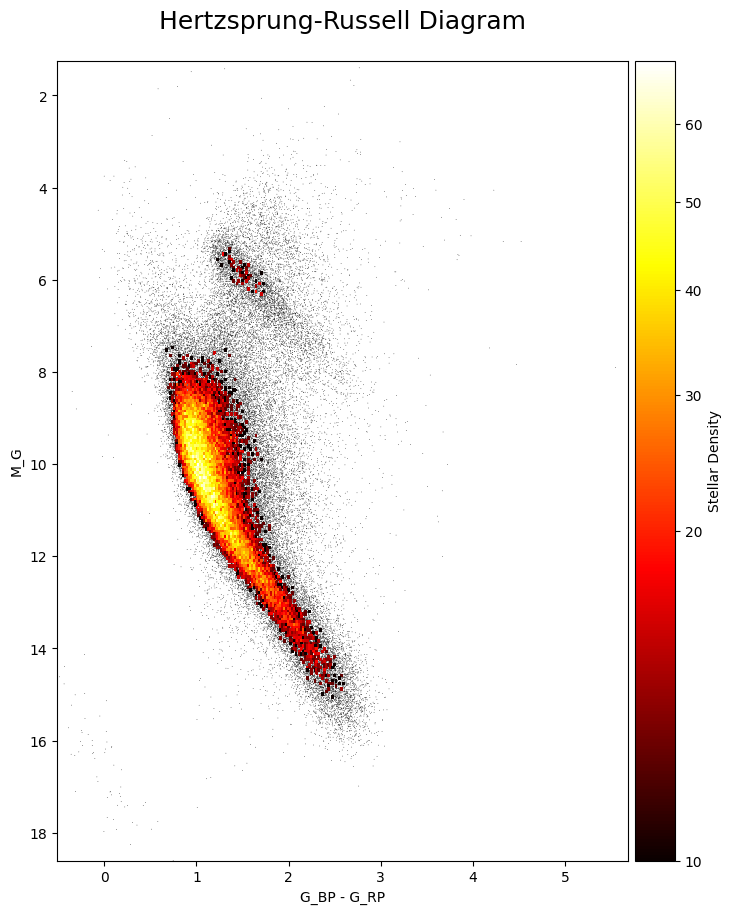

In [ ]:
# plot HRD

fig = plt.figure(figsize=(8, 10),dpi=100)
ax = fig.add_axes([.1, .1, .85, .8])
ax.set_title('Hertzsprung-Russell Diagram', fontsize=18)
ax.title.set_position([.5, 1.03])
ax.set_xlabel('G_BP - G_RP')
ax.set_ylabel('M_G')
h = ax.hist2d(data['bp_rp'],data['g_abs'], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5, cmap ='hot')
ax.scatter(data['bp_rp'],data['g_abs'],marker='.',s=[1] * len(data),color = 'k',linewidth=0,zorder=0)
cb = fig.colorbar(h[3], ax=ax, pad=0.01)
cb.set_label("Stellar Density")
ax.invert_yaxis()

# uncomment to save figure
plt.savefig("Hertzsprung-Russell.png", dpi=100)



# **Gaia HRD of sources with low extinction (E(B − V) < 0.015 mag)**

Add additional filter (E(B − V) < 0.015 mag) on previous data to plot low-extinction HRD

In [ ]:
low_extinction_mask = data['e_bp_min_rp_val']< 0.015
data_low_extinction = data[low_extinction_mask]
data_low_extinction

,source_id,ra,dec,parallax,visibility_periods_used,astrometric_excess_noise,parallax_over_error,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_rp_excess_factor,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,phot_g_mean_mag,bp_rp,e_bp_min_rp_val,g_abs
11,3057044441536096640,114.366275,-4.737964,0.259264,14,0.000000,10.000001,5610.098633,1599.505493,1333.088623,1.246360,14.200095,12.949284,190.060165,308,13.643339,1.250812,0.0110,5.712050
177,5005277959600020352,7.892051,-35.002064,0.572062,14,0.000000,10.000029,1843.220825,391.493713,314.803589,1.211997,16.292717,15.609619,223.077179,247,16.038050,0.683098,0.0130,9.825264
205,6298323936174652288,216.806422,-16.533051,0.742390,10,0.000000,10.000033,1372.377930,224.485031,225.395386,1.224219,16.828955,15.863205,118.752579,123,16.428644,0.965750,0.0120,10.781806
264,4582315490168389248,267.568870,26.566990,0.581919,16,0.000000,10.000044,1425.745483,290.740356,167.427765,1.217408,16.738617,15.901800,267.569214,276,16.405907,0.836817,0.0067,10.230218
283,28509275651979392,42.679657,11.924650,0.757009,10,0.089424,10.000049,1085.740845,377.053589,156.688004,1.253094,17.206028,16.106062,177.126358,160,16.750410,1.099966,0.0105,11.145916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94744,5661263123767295360,143.792218,-25.864115,0.648501,11,0.000000,10.014891,1862.832764,409.149506,376.538574,1.210933,16.536224,15.659527,268.183655,272,16.175341,0.876698,0.0060,10.234895
94860,1320610157559137280,240.816370,31.013903,0.668306,18,0.000000,10.014911,1454.972168,287.883209,154.925339,1.227990,17.481981,16.399120,328.095001,318,17.014887,1.082861,0.0080,11.139765
94912,4832745859145238144,53.634705,-49.517155,0.653325,16,0.202762,10.014920,1213.581055,237.008087,104.771004,1.222080,17.178947,16.198652,266.653931,217,16.768194,0.980295,0.0070,10.843840
94920,1511275953536359680,211.274771,49.444991,0.595687,21,0.139308,10.014921,1616.751709,297.027039,238.332092,1.223850,17.025972,16.057306,326.598907,270,16.623625,0.968666,0.0127,10.498716


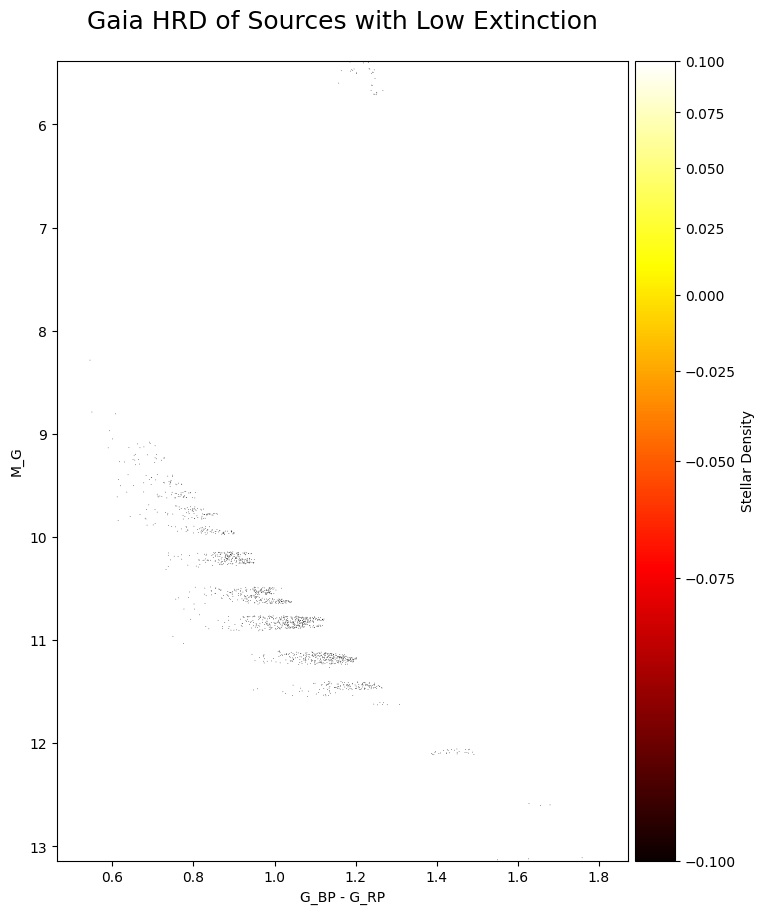

In [ ]:
# plot HRD

fig = plt.figure(figsize=(8, 10),dpi=100)
ax = fig.add_axes([.1, .1, .85, .8])
ax.set_title('Gaia HRD of Sources with Low Extinction', fontsize=18)
ax.title.set_position([.5, 1.03])
ax.set_xlabel('G_BP - G_RP')
ax.set_ylabel('M_G')
h = ax.hist2d(data_low_extinction['bp_rp'],data_low_extinction['g_abs'], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5, cmap ='hot')
ax.scatter(data_low_extinction['bp_rp'],data_low_extinction['g_abs'],marker='.',s=[1] * len(data_low_extinction),color = 'k',linewidth=0,zorder=0)
cb = fig.colorbar(h[3], ax=ax, pad=0.01)
cb.set_label("Stellar Density")
ax.invert_yaxis()

# uncomment to save figure
#plt.savefig("Hertzsprung-Russell.png", dpi=100)

# **HR diagram for the data from EDR3**

This is different algorithm to plot HRDs with different filters

In [ ]:
import urllib
links = [
    'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_000000-003111.csv.gz',
   'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_003112-005263.csv.gz',
    'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_005264-006601.csv.gz',
	'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_006602-007952.csv.gz',
    'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_007953-010234.csv.gz',
	'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_010235-012597.csv.gz',
  'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_012598-014045.csv.gz',
  'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_014046-015369.csv.gz',
	'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_015370-016240.csv.gz',
	'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/GaiaSource_016241-017018.csv.gz',
]

In [ ]:
# A function to parse data and concat them

def csv_parser(a = len(links)):
  x = []
  for i in range(0,a):
    data = pd.read_csv(links[i],index_col=0)
    x.append(data)
  return pd.concat(x) 

In [ ]:
data_dr3 = csv_parser()
print('data is ready (:')
data_dr3.info()

data is ready (:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5188367 entries, 1636042515805110273 to 1636042515805110273
Data columns (total 98 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   designation                      object 
 1   source_id                        int64  
 2   random_index                     int64  
 3   ref_epoch                        float64
 4   ra                               float64
 5   ra_error                         float64
 6   dec                              float64
 7   dec_error                        float64
 8   parallax                         float64
 9   parallax_error                   float64
 10  parallax_over_error              float64
 11  pm                               float64
 12  pmra                             float64
 13  pmra_error                       float64
 14  pmdec                            float64
 15  pmdec_error                      float64
 16  ra_dec_

In [ ]:
# removes strong outliers, in particular at the faint end of the local HRD

total_mask = (data_dr3['visibility_periods_used']>8) & (data_dr3['astrometric_excess_noise']<1)
data_dr3 = data_dr3.loc[total_mask]
data_dr3

,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,...,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
solution_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1636042515805110273,Gaia EDR3 4295806720,4295806720,1067963836,2016.0,44.996155,0.101618,0.005615,0.101334,0.354331,0.122664,2.888632,12.616485,11.938352,0.137942,-4.080619,0.133170,0.122935,0.132028,-0.088910,0.022551,-0.365342,-0.036904,-0.244838,0.063012,0.135709,0.334337,184,0,183,1,2.672049,242.20697,0.380619,2.076508,31,False,1.508939,NaN,NaN,NaN,...,0.842078,-87.754780,-30.694550,-46.201910,30.174356,False,182,1653.394716,2.075764,796.52340,17.641426,18,800.429546,12.601409,63.519050,18.080235,20,1187.588004,15.823832,75.050600,17.061232,0.0,0.0,0.0,2.0,0.0,1.202385,1.019003,0.438808,0.580194,NaN,NaN,0,NaN,NaN,NaN,176.951076,-48.901521,42.533726,-16.329574
1636042515805110273,Gaia EDR3 34361129088,34361129088,1721389493,2016.0,45.004320,0.097320,0.021048,0.101753,3.235017,0.120450,26.857704,35.230515,29.518344,0.133693,19.231655,0.133922,0.163253,0.000643,-0.073663,-0.012017,-0.403893,-0.101522,-0.315934,0.140650,0.231426,0.381754,172,0,171,1,1.081467,194.59933,0.267413,1.032802,31,False,1.285487,NaN,NaN,NaN,...,0.848356,-101.856606,-31.586445,-44.381237,29.909302,False,170,1763.191387,2.121236,831.20960,17.571619,18,389.997136,9.491409,41.089485,18.860890,19,2178.214858,15.074686,144.494870,16.402643,0.0,2.0,0.0,1.0,0.0,1.456570,2.458246,1.289270,1.168976,NaN,NaN,0,NaN,NaN,NaN,176.942789,-48.884934,42.546573,-16.317212
1636042515805110273,Gaia EDR3 38655544960,38655544960,1553909024,2016.0,45.004978,0.017885,0.019880,0.018772,3.139170,0.022347,140.471310,35.308210,29.686339,0.023772,19.115200,0.023830,0.115263,0.073231,-0.106919,-0.030214,-0.448866,-0.155514,-0.379279,0.181846,0.263670,0.355281,183,0,182,1,0.264343,181.43846,0.000000,0.000000,31,False,1.455016,NaN,NaN,NaN,...,0.846566,-96.318890,-34.497215,-44.825780,30.347420,False,180,42030.600439,11.392837,3689.21300,14.128453,20,17955.479377,26.039320,689.552550,14.703050,19,34263.487540,36.751350,932.305540,13.410816,0.0,3.0,0.0,2.0,0.0,1.242403,1.292233,0.574596,0.717637,NaN,NaN,0,NaN,NaN,NaN,176.944762,-48.885270,42.546872,-16.318522
1636042515805110273,Gaia EDR3 309238066432,309238066432,962691240,2016.0,44.995037,0.322039,0.038152,0.283505,1.383150,0.367907,3.759512,1.472751,0.710339,0.427646,-1.290122,0.364729,0.031063,0.200474,0.053647,0.059748,-0.221020,-0.016839,-0.136630,0.179964,0.052951,0.211478,191,0,191,0,-0.241182,192.30405,0.000000,0.000000,95,False,NaN,1.286628,0.090775,-0.157192,...,0.846794,-67.002000,-0.060676,-50.141193,28.862438,False,191,269.194132,1.108006,242.95375,19.612204,15,70.1743

In [ ]:
#These criteria may remove variable stars

mask_first = (data_dr3['parallax_over_error'] > 10) & (data_dr3['phot_g_mean_flux_over_error'] > 50) & (data_dr3['phot_rp_mean_flux_over_error'] > 20) & (data_dr3['phot_bp_mean_flux_over_error'] > 20)
data_dr3_first = data_dr3.loc[mask_first]
data_dr3_first

,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,...,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
solution_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1636042515805110273,Gaia EDR3 34361129088,34361129088,1721389493,2016.0,45.004320,0.097320,0.021048,0.101753,3.235017,0.120450,26.857704,35.230515,29.518344,0.133693,19.231655,0.133922,0.163253,0.000643,-0.073663,-0.012017,-0.403893,-0.101522,-0.315934,0.140650,0.231426,0.381754,172,0,171,1,1.081467,194.59933,0.267413,1.032802,31,False,1.285487,NaN,NaN,NaN,...,0.848356,-101.856606,-31.586445,-44.381237,29.909302,False,170,1763.191387,2.121236,831.2096,17.571619,18,389.997136,9.491409,41.089485,18.860890,19,2178.214858,15.074686,144.49487,16.402643,0.0,2.0,0.0,1.0,0.0,1.456570,2.458246,1.289270,1.168976,NaN,NaN,0,NaN,NaN,NaN,176.942789,-48.884934,42.546573,-16.317212
1636042515805110273,Gaia EDR3 38655544960,38655544960,1553909024,2016.0,45.004978,0.017885,0.019880,0.018772,3.139170,0.022347,140.471310,35.308210,29.686339,0.023772,19.115200,0.023830,0.115263,0.073231,-0.106919,-0.030214,-0.448866,-0.155514,-0.379279,0.181846,0.263670,0.355281,183,0,182,1,0.264343,181.43846,0.000000,0.000000,31,False,1.455016,NaN,NaN,NaN,...,0.846566,-96.318890,-34.497215,-44.825780,30.347420,False,180,42030.600439,11.392837,3689.2130,14.128453,20,17955.479377,26.039320,689.552550,14.703050,19,34263.487540,36.751350,932.30554,13.410816,0.0,3.0,0.0,2.0,0.0,1.242403,1.292233,0.574596,0.717637,NaN,NaN,0,NaN,NaN,NaN,176.944762,-48.885270,42.546872,-16.318522
1636042515805110273,Gaia EDR3 549755818112,549755818112,1638831585,2016.0,45.048282,0.027804,0.048254,0.026500,1.583477,0.034425,45.997280,16.465364,0.843128,0.038817,-16.443764,0.032920,0.150414,-0.141034,0.058549,0.176110,-0.474100,0.199068,0.040113,-0.144958,-0.137338,0.258817,186,0,185,1,1.736130,220.66844,0.072145,0.965630,31,True,1.464321,NaN,NaN,NaN,...,0.842158,-121.244050,-9.218482,-38.814762,29.860806,False,182,19047.581229,6.548358,2908.7566,14.987767,18,8336.447382,16.801348,496.177300,15.536090,17,15362.299345,18.731024,820.15265,14.281755,0.0,0.0,0.0,0.0,0.0,1.244187,1.254335,0.548323,0.706013,NaN,NaN,0,NaN,NaN,NaN,176.959366,-48.834398,42.598673,-16.304077
1636042515805110273,Gaia EDR3 828929527040,828929527040,1688599581,2016.0,45.023620,0.054348,0.068419,0.057793,1.203095,0.066816,18.006063,17.646046,13.952005,0.078203,-10.803909,0.077210,0.151767,0.035847,-0.174849,-0.019222,-0.438190,-0.130195,-0.382967,0.187084,0.243698,0.374865,180,0,174,6,0.674236,189.07535,0.000000,0.000000,31,False,1.428080,NaN,NaN,NaN,...,0.841352,-94.506330,-34.891853,-45.023620,30.440960,False,175,4394.201552,3.346940,1312.9012,16.580168,15,1758.2

In [ ]:
# we have limitedour analysis to the sources within the empirically defined locus
#of the (I BP + I RP )/I G fluxes ratio as a function of G BP − G RP colour

mask_second = (data_dr3_first['phot_bp_rp_excess_factor'] < 1.3+0.06*(data_dr3_first['phot_bp_mean_mag']-data_dr3_first['phot_rp_mean_mag'])**2) & (data_dr3_first['phot_bp_rp_excess_factor'] > 1.0+0.015*(data_dr3_first['phot_bp_mean_mag']-data_dr3_first['phot_rp_mean_mag'])**2)
data_dr3_second = data_dr3_first.loc[mask_second]
data_dr3_second

,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,...,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
solution_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1636042515805110273,Gaia EDR3 34361129088,34361129088,1721389493,2016.0,45.004320,0.097320,0.021048,0.101753,3.235017,0.120450,26.857704,35.230515,29.518344,0.133693,19.231655,0.133922,0.163253,0.000643,-0.073663,-0.012017,-0.403893,-0.101522,-0.315934,0.140650,0.231426,0.381754,172,0,171,1,1.081467,194.59933,0.267413,1.032802,31,False,1.285487,NaN,NaN,NaN,...,0.848356,-101.856606,-31.586445,-44.381237,29.909302,False,170,1763.191387,2.121236,831.2096,17.571619,18,389.997136,9.491409,41.089485,18.860890,19,2178.214858,15.074686,144.49487,16.402643,0.0,2.0,0.0,1.0,0.0,1.456570,2.458246,1.289270,1.168976,NaN,NaN,0,NaN,NaN,NaN,176.942789,-48.884934,42.546573,-16.317212
1636042515805110273,Gaia EDR3 38655544960,38655544960,1553909024,2016.0,45.004978,0.017885,0.019880,0.018772,3.139170,0.022347,140.471310,35.308210,29.686339,0.023772,19.115200,0.023830,0.115263,0.073231,-0.106919,-0.030214,-0.448866,-0.155514,-0.379279,0.181846,0.263670,0.355281,183,0,182,1,0.264343,181.43846,0.000000,0.000000,31,False,1.455016,NaN,NaN,NaN,...,0.846566,-96.318890,-34.497215,-44.825780,30.347420,False,180,42030.600439,11.392837,3689.2130,14.128453,20,17955.479377,26.039320,689.552550,14.703050,19,34263.487540,36.751350,932.30554,13.410816,0.0,3.0,0.0,2.0,0.0,1.242403,1.292233,0.574596,0.717637,NaN,NaN,0,NaN,NaN,NaN,176.944762,-48.885270,42.546872,-16.318522
1636042515805110273,Gaia EDR3 549755818112,549755818112,1638831585,2016.0,45.048282,0.027804,0.048254,0.026500,1.583477,0.034425,45.997280,16.465364,0.843128,0.038817,-16.443764,0.032920,0.150414,-0.141034,0.058549,0.176110,-0.474100,0.199068,0.040113,-0.144958,-0.137338,0.258817,186,0,185,1,1.736130,220.66844,0.072145,0.965630,31,True,1.464321,NaN,NaN,NaN,...,0.842158,-121.244050,-9.218482,-38.814762,29.860806,False,182,19047.581229,6.548358,2908.7566,14.987767,18,8336.447382,16.801348,496.177300,15.536090,17,15362.299345,18.731024,820.15265,14.281755,0.0,0.0,0.0,0.0,0.0,1.244187,1.254335,0.548323,0.706013,NaN,NaN,0,NaN,NaN,NaN,176.959366,-48.834398,42.598673,-16.304077
1636042515805110273,Gaia EDR3 828929527040,828929527040,1688599581,2016.0,45.023620,0.054348,0.068419,0.057793,1.203095,0.066816,18.006063,17.646046,13.952005,0.078203,-10.803909,0.077210,0.151767,0.035847,-0.174849,-0.019222,-0.438190,-0.130195,-0.382967,0.187084,0.243698,0.374865,180,0,174,6,0.674236,189.07535,0.000000,0.000000,31,False,1.428080,NaN,NaN,NaN,...,0.841352,-94.506330,-34.891853,-45.023620,30.440960,False,175,4394.201552,3.346940,1312.9012,16.580168,15,1758.2

In [ ]:
mask_third = data_dr3_second['astrometric_chi2_al']/(data_dr3_second['astrometric_n_good_obs_al']-5) < 1.44*np.maximum(1, np.exp(-0.4*(data_dr3_second['phot_g_mean_mag']-19.5)))
data_dr3_third  = data_dr3_second.loc[mask_third]
data_dr3_third 

,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,...,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
solution_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1636042515805110273,Gaia EDR3 34361129088,34361129088,1721389493,2016.0,45.004320,0.097320,0.021048,0.101753,3.235017,0.120450,26.857704,35.230515,29.518344,0.133693,19.231655,0.133922,0.163253,0.000643,-0.073663,-0.012017,-0.403893,-0.101522,-0.315934,0.140650,0.231426,0.381754,172,0,171,1,1.081467,194.59933,0.267413,1.032802,31,False,1.285487,NaN,NaN,NaN,...,0.848356,-101.856606,-31.586445,-44.381237,29.909302,False,170,1763.191387,2.121236,831.2096,17.571619,18,389.997136,9.491409,41.089485,18.860890,19,2178.214858,15.074686,144.49487,16.402643,0.0,2.0,0.0,1.0,0.0,1.456570,2.458246,1.289270,1.168976,NaN,NaN,0,NaN,NaN,NaN,176.942789,-48.884934,42.546573,-16.317212
1636042515805110273,Gaia EDR3 38655544960,38655544960,1553909024,2016.0,45.004978,0.017885,0.019880,0.018772,3.139170,0.022347,140.471310,35.308210,29.686339,0.023772,19.115200,0.023830,0.115263,0.073231,-0.106919,-0.030214,-0.448866,-0.155514,-0.379279,0.181846,0.263670,0.355281,183,0,182,1,0.264343,181.43846,0.000000,0.000000,31,False,1.455016,NaN,NaN,NaN,...,0.846566,-96.318890,-34.497215,-44.825780,30.347420,False,180,42030.600439,11.392837,3689.2130,14.128453,20,17955.479377,26.039320,689.552550,14.703050,19,34263.487540,36.751350,932.30554,13.410816,0.0,3.0,0.0,2.0,0.0,1.242403,1.292233,0.574596,0.717637,NaN,NaN,0,NaN,NaN,NaN,176.944762,-48.885270,42.546872,-16.318522
1636042515805110273,Gaia EDR3 549755818112,549755818112,1638831585,2016.0,45.048282,0.027804,0.048254,0.026500,1.583477,0.034425,45.997280,16.465364,0.843128,0.038817,-16.443764,0.032920,0.150414,-0.141034,0.058549,0.176110,-0.474100,0.199068,0.040113,-0.144958,-0.137338,0.258817,186,0,185,1,1.736130,220.66844,0.072145,0.965630,31,True,1.464321,NaN,NaN,NaN,...,0.842158,-121.244050,-9.218482,-38.814762,29.860806,False,182,19047.581229,6.548358,2908.7566,14.987767,18,8336.447382,16.801348,496.177300,15.536090,17,15362.299345,18.731024,820.15265,14.281755,0.0,0.0,0.0,0.0,0.0,1.244187,1.254335,0.548323,0.706013,NaN,NaN,0,NaN,NaN,NaN,176.959366,-48.834398,42.598673,-16.304077
1636042515805110273,Gaia EDR3 828929527040,828929527040,1688599581,2016.0,45.023620,0.054348,0.068419,0.057793,1.203095,0.066816,18.006063,17.646046,13.952005,0.078203,-10.803909,0.077210,0.151767,0.035847,-0.174849,-0.019222,-0.438190,-0.130195,-0.382967,0.187084,0.243698,0.374865,180,0,174,6,0.674236,189.07535,0.000000,0.000000,31,False,1.428080,NaN,NaN,NaN,...,0.841352,-94.506330,-34.891853,-45.023620,30.440960,False,175,4394.201552,3.346940,1312.9012,16.580168,15,1758.2

In [ ]:
# total mask

data_dr3 = data_dr3[['ra', 'dec', 'parallax', 'phot_g_mean_mag', 'bp_rp',
'astrometric_excess_noise',
'phot_bp_rp_excess_factor']]

# first mask

data_dr3_first = data_dr3_first[['ra', 'dec', 'parallax', 'phot_g_mean_mag', 'bp_rp',
'astrometric_excess_noise',
'phot_bp_rp_excess_factor']]

# second mask

data_dr3_second = data_dr3_second[['ra', 'dec', 'parallax', 'phot_g_mean_mag', 'bp_rp',
'astrometric_excess_noise',
'phot_bp_rp_excess_factor']]

# third mask

data_dr3_third = data_dr3_third[['ra', 'dec', 'parallax', 'phot_g_mean_mag', 'bp_rp',
'astrometric_excess_noise',
'phot_bp_rp_excess_factor']]

In [ ]:
# total mask
g_abs = data_dr3['phot_g_mean_mag']+ 5 + 5*np.log10(data_dr3['parallax']/1000)
data_dr3 = pd.concat([data_dr3,g_abs],axis = 1)
data_dr3.rename(index=str,columns={0:'g_abs'},inplace=True)

# first mask
g_abs_first = data_dr3_first['phot_g_mean_mag']+ 5 + 5*np.log10(data_dr3_first['parallax']/1000)
data_dr3_first = pd.concat([data_dr3_first,g_abs_first],axis = 1)
data_dr3_first.rename(index=str,columns={0:'g_abs_first'},inplace=True)

# second mask
g_abs_second = data_dr3_second['phot_g_mean_mag']+ 5 + 5*np.log10(data_dr3_second['parallax']/1000)
data_dr3_second = pd.concat([data_dr3_second,g_abs_second],axis = 1)
data_dr3_second.rename(index=str,columns={0:'g_abs_second'},inplace=True)

# third mask
g_abs_third = data_dr3_third['phot_g_mean_mag']+ 5 + 5*np.log10(data_dr3_third['parallax']/1000)
data_dr3_third = pd.concat([data_dr3_third,g_abs_third],axis = 1)
data_dr3_third.rename(index=str,columns={0:'g_abs_third'},inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data_dr3 = data_dr3.dropna()
data_dr3_first = data_dr3_first.dropna()
data_dr3_second = data_dr3_second.dropna()

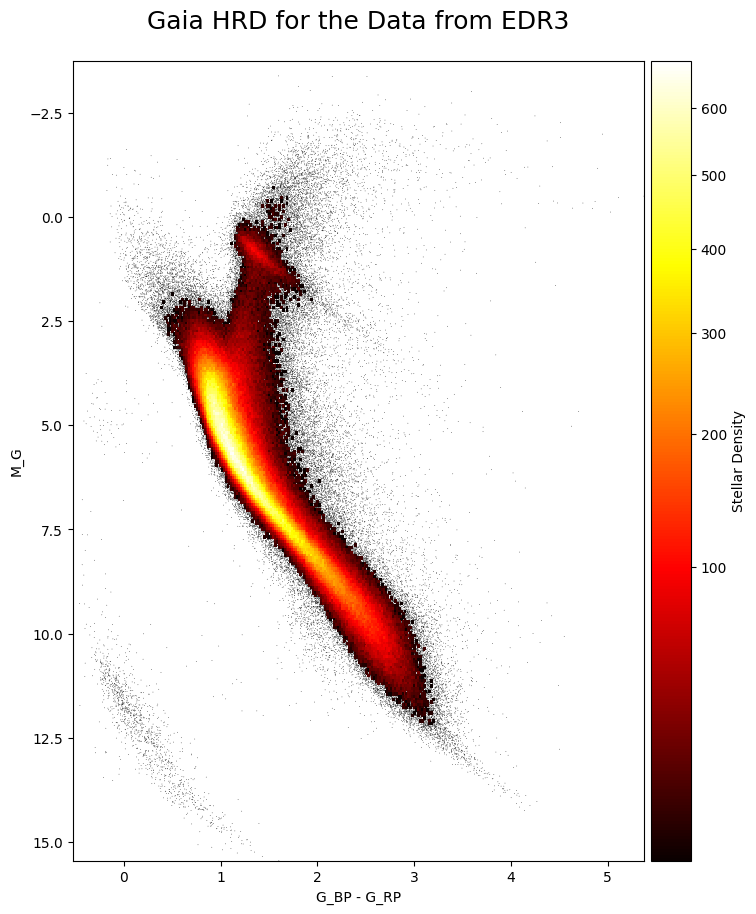

In [ ]:
# plot HRD

fig = plt.figure(figsize=(8, 10),dpi=100)
ax = fig.add_axes([.1, .1, .85, .8])
ax.set_title('Gaia HRD for the Data from EDR3', fontsize=18)
ax.title.set_position([.5, 1.03])
ax.set_xlabel('G_BP - G_RP')
ax.set_ylabel('M_G')
h = ax.hist2d(data_dr3_third['bp_rp'],data_dr3_third['g_abs_third'], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5, cmap ='hot')
ax.scatter(data_dr3_third['bp_rp'],data_dr3_third['g_abs_third'],marker='.',s=[1] * len(data_dr3_third),color = 'k',linewidth=0,zorder=0)
cb = fig.colorbar(h[3], ax=ax, pad=0.01)
cb.set_label("Stellar Density")
ax.invert_yaxis()

# uncomment to save figure
plt.savefig("Hertzsprung-Russell-dr3.png", dpi=100)

#**HR diagram for NGC_104_47Tuc Cluster**

In [32]:
!git clone https://github.com/GalacticDynamics-Oxford/GaiaTools.git
!cd GaiaTools/
!ls

fatal: destination path 'GaiaTools' already exists and is not an empty directory.
data		input.txt	       README		  run_orbits.py
GaiaTools	McMillan17.ini	       result_orbits.txt
get_mean_pm.py	__pycache__	       result.txt
__init__.py	query_gaia_archive.py  run_fit.py


In [33]:
example1 = "/content/GaiaTools/input.txt"
file1 = open(example1, "r")
FileContent = file1.read()
FileContent

'# Name         \t     ra\t    dec\t   dist\tdisterr\t   vlos\tvloserr\t  sigma\t   rmax\t   pmra\t  pmdec\t    plx\t pmra_e\tpmdec_e\t pmcorr\t  plx_e\nNGC_104_47Tuc  \t  6.024\t-72.081\t   4.52\t   0.03\t -17.45\t   0.16\t   12.2\t   40.0\t 5.2516\t-2.5515\t 0.2318\t 0.0214\t 0.0214\t-0.0023\t 0.0095\nNGC_288        \t 13.188\t-26.583\t   8.99\t   0.09\t -44.45\t   0.13\t    3.3\t   15.0\t 4.1641\t-5.7053\t 0.1410\t 0.0241\t 0.0243\t 0.0094\t 0.0106\nNGC_362        \t 15.809\t-70.849\t   8.83\t   0.10\t 223.12\t   0.28\t    8.8\t   12.0\t 6.6935\t-2.5354\t 0.1141\t 0.0245\t 0.0242\t 0.0039\t 0.0105\nWhiting_1      \t 30.737\t -3.253\t  30.59\t   1.17\t-130.41\t   1.79\t    0.3\t    3.0\t-0.2277\t-2.0458\t 0.0168\t 0.0653\t 0.0561\t 0.0333\t 0.0469\nNGC_1261       \t 48.068\t-55.216\t  16.40\t   0.19\t  71.34\t   0.21\t    5.8\t   10.0\t 1.5957\t-2.0642\t 0.0679\t 0.0249\t 0.0251\t 0.0082\t 0.0108\nPal_1          \t 53.333\t 79.581\t  11.18\t   0.32\t -75.72\t   0.29\t    0.5\t    3.0

# **Define a list of clusters**
You can choice any cluster and plot its HR diagram

In [35]:
import numpy, os
if not os.path.isdir('data'):
    os.mkdir('data')

# this is the basic interface for querying the Gaia archive
from astroquery.utils.tap.core import Tap
gaia = Tap(url="https://gea.esac.esa.int/tap-server/tap")

# parallax zero-point correction from Lindegren+2020
try:
    from zero_point import zpt
    zpt.load_tables()
except Exception as ex:
    print("Parallax zero-point correction not available: "+str(ex))
    zpt = None

def retrieve(ra, dec, radius, filename, parallax0):
    """
    Query the Gaia archive for all sources within a certain radius from the given point,
    which have parallax below the given limit (within 3 sigma),
    and save the result as a numpy zip archive.
    """
    job = gaia.launch_job("select top 999999 "+
        "ra, dec, parallax, phot_rp_mean_flux_over_error,parallax_over_error, parallax_error, pmra, pmra_error, pmdec, pmdec_error, pmra_pmdec_corr, "+
        "phot_g_mean_mag,astrometric_n_good_obs_al, phot_rp_mean_mag, phot_g_mean_flux_over_error, bp_rp, ruwe, visibility_periods_used, astrometric_excess_noise, phot_bp_rp_excess_factor, "+
        "nu_eff_used_in_astrometry,astrometric_chi2_al, phot_bp_mean_flux_over_error,phot_bp_mean_mag,dr2_rv_template_fe_h, pseudocolour, ecl_lat, astrometric_params_solved "+
        #"dr2_rv_template_fe_h , astrometric_n_good_obs_al, astrometric_chi2_al "+
        "FROM gaiaedr3.gaia_source WHERE "
        "phot_g_mean_mag<=21 and parallax is not null and "+
        "abs(parallax%+.3f"%(-parallax0)+")<3*parallax_error and "+
        "contains(point('icrs',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec), "+
        "circle('icrs',"+str(ra)+","+str(dec)+","+str(radius)+"))=1")
    table = job.get_results()
    print("%s => %d" % (filename, len(table)))
    # apply parallax zero-point correction
    phot_g_mean_mag = numpy.array(table['phot_g_mean_mag'])
    parallax = numpy.array(table['parallax'])
    if zpt is not None:
        parallax -= numpy.nan_to_num(zpt.get_zpt(phot_g_mean_mag,
            table['nu_eff_used_in_astrometry'], table['pseudocolour'], table['ecl_lat'],
            table['astrometric_params_solved'], _warnings=True))
    # save the data as a numpy zip archive
    numpy.savez_compressed("data/"+filename,
        ra = numpy.array(table['ra']).astype(numpy.float32),
        dec = numpy.array(table['dec']).astype(numpy.float32),
        parallax = parallax.astype(numpy.float32),
        parallax_error = numpy.array(table['parallax_error']).astype(numpy.float32),
        parallax_over_error = numpy.array(table['parallax_over_error']).astype(numpy.float32),
        visibility_periods_used = numpy.array(table['visibility_periods_used']).astype(numpy.float32),
        phot_g_mean_flux_over_error = numpy.array(table['phot_g_mean_flux_over_error']).astype(numpy.float32),
        phot_rp_mean_flux_over_error = numpy.array(table['phot_rp_mean_flux_over_error']).astype(numpy.float32),
        phot_bp_mean_flux_over_error = numpy.array(table['phot_bp_mean_flux_over_error']).astype(numpy.float32),
        phot_bp_mean_mag = numpy.array(table['phot_bp_mean_mag']).astype(numpy.float32),
        phot_rp_mean_mag = numpy.array(table['phot_rp_mean_mag']).astype(numpy.float32),
        astrometric_chi2_al = numpy.array(table['astrometric_chi2_al']).astype(numpy.float32),
        astrometric_n_good_obs_al = numpy.array(table['astrometric_n_good_obs_al']).astype(numpy.float32),
        dr2_rv_template_fe_h = numpy.array(table['dr2_rv_template_fe_h']).astype(numpy.float64),
        #e_bp_min_rp_val = numpy.array(table['e_bp_min_rp_val']).astype(numpy.float32),
        pmra = numpy.array(table['pmra']).astype(numpy.float32),
        pmdec= numpy.array(table['pmdec']).astype(numpy.float32),
        pmra_error = numpy.array(table['pmra_error']).astype(numpy.float32),
        pmdec_error = numpy.array(table['pmdec_error']).astype(numpy.float32),
        pmra_pmdec_corr = numpy.array(table['pmra_pmdec_corr']).astype(numpy.float32),
        phot_g_mean_mag = phot_g_mean_mag.astype(numpy.float32),
        bp_rp = numpy.array(table['bp_rp']).astype(numpy.float32),
        ruwe = numpy.array(table['ruwe']).astype(numpy.float32),
        astrometric_excess_noise = numpy.array(table['astrometric_excess_noise']).astype(numpy.float32),
        phot_bp_rp_excess_factor = numpy.array(table['phot_bp_rp_excess_factor']).astype(numpy.float32),
        fiveparam = numpy.array(table['astrometric_params_solved'])==31
    )

# read the list of clusters and query the Gaia archive for each of them
lst = numpy.genfromtxt('input.txt', dtype=str)
for l in lst:
    retrieve(ra=float(l[1]), dec=float(l[2]), radius=float(l[8])/60,  # convert from arcmin to degrees
        filename=l[0], parallax0=1./float(l[3])-0.03)

Parallax zero-point correction not available: No module named 'zero_point'
NGC_104_47Tuc => 131529
NGC_288 => 11453
NGC_362 => 17208
Whiting_1 => 46
NGC_1261 => 5085
Pal_1 => 174
AM_1 => 63
Eridanus => 70
Pal_2 => 523
NGC_1851 => 11041
NGC_1904_M_79 => 6755
NGC_2298 => 3648
NGC_2419 => 1669
Ko_2 => 18
Pyxis => 448
NGC_2808 => 26877
E_3 => 625
Pal_3 => 68
NGC_3201 => 55730
ESO_93-8 => 1006
Pal_4 => 108
Crater => 33
Bliss_1 => 112
Ko_1 => 9
NGC_4147 => 1225
NGC_4372 => 33390
Rup_106 => 1259
NGC_4590_M_68 => 9229
BH_140 => 29996
NGC_4833 => 26634
NGC_5024_M_53 => 9936
NGC_5053 => 2991
Kim_3 => 46
NGC_5139_oCen => 201994
NGC_5272_M_3 => 26226
NGC_5286 => 9908
AM_4 => 29
NGC_5466 => 5214
NGC_5634 => 1413
NGC_5694 => 855
IC_4499 => 2998
Munoz_1 => 18
NGC_5824 => 2823
Pal_5 => 692
NGC_5897 => 7586
NGC_5904_M_5 => 26230
NGC_5927 => 33606
NGC_5946 => 8521
BH_176 => 2980
NGC_5986 => 9319
FSR_1716 => 5600
Pal_14 => 176
Lynga_7_BH184 => 8945
NGC_6093_M_80 => 6185
Ryu_059_RLGC1 => 130
NGC_6121_M_4 

# **Get the data of clusters**

In [36]:
# whether to account for spatially correlated systematic errors when estimating the uncertainty on mean PM
use_systematic_error = True
if use_systematic_error:
    import get_mean_pm

import numpy, scipy.optimize
try:
    # autograd module allows to compute analytically the Hessian of the log-likelihood function
    import autograd
    log  = autograd.numpy.log
    exp  = autograd.numpy.exp
except ImportError:
    # will not be able to compute statistical uncertainties if autograd is not available,
    # however, if use_systematic_error==True, the uncertainties will be computed in a different way
    # which does not use autograd anyway
    autograd = None
    log  = numpy.log
    exp  = numpy.exp

filein   = open("input.txt",  "r")
fileout  = open("result.txt", 'w')
for linein in filein:
    # parse the input file (one line per cluster)
    line  = linein.strip().split()
    name  = line[0]
    if linein[0]=='#':
        fileout.write(linein)
        continue
    ra0   = float(line[1])  # degrees
    dec0  = float(line[2])  # degrees
    dist  = float(line[3])  # kpc
    vdisp = float(line[7])  # km/s
    rmax  = float(line[8])  # arcmin
    pmra0 = float(line[9])  # initial guess for the cluster PMra
    pmdec0= float(line[10]) # same for PMdec

    # read data file that was previously retrieved from the Gaia archive
    data  = numpy.load('data/'+name+'.npz')
    ra    = data['ra'].astype(float)
    dec   = data['dec'].astype(float)
    pmra  = data['pmra'].astype(float)
    parallax_over_error = data['parallax_over_error'].astype(float)
    visibility_periods_used = data['visibility_periods_used'].astype(float)
    phot_g_mean_flux_over_error = data['phot_g_mean_flux_over_error'].astype(float)
    phot_rp_mean_flux_over_error = data['phot_rp_mean_flux_over_error'].astype(float)
    phot_bp_mean_flux_over_error = data['phot_bp_mean_flux_over_error'].astype(float)
    phot_bp_mean_mag = data['phot_bp_mean_mag'].astype(float)
    phot_rp_mean_mag = data['phot_rp_mean_mag'].astype(float)
    astrometric_chi2_al = data['astrometric_chi2_al'].astype(float)
    astrometric_n_good_obs_al = data['astrometric_n_good_obs_al'].astype(float)
    dr2_rv_template_fe_h = data['dr2_rv_template_fe_h'].astype(float)

    pmdec = data['pmdec'].astype(float)
    pmrae = data['pmra_error'].astype(float)
    pmdece= data['pmdec_error'].astype(float)
    pmcorr= data['pmra_pmdec_corr'].astype(float)
    plx   = data['parallax'].astype(float)
    plxe  = data['parallax_error'].astype(float)
    bprp  = data['bp_rp']
    gmag  = data['phot_g_mean_mag']
    ruwe  = data['ruwe']
    aen   = data['astrometric_excess_noise']
    penn  = numpy.where(bprp<0.5, 1.1544+0.0338*bprp+0.0323*bprp**2,
            numpy.where(bprp<4.0, 1.1620+0.0115*bprp+0.0493*bprp**2-0.00588*bprp**3, 1.0576+0.1405*bprp))
    pen   = data['phot_bp_rp_excess_factor'] - penn  # excess flux minus the global trend
    pens  = pen / (0.006 + 8.8e-12 * gmag**7.62)     # magnitude-dependent scaling factor

    # coordinate transformation from sky to tangent plane (orthogonal projection)
    sin   = numpy.sin
    cos   = numpy.cos
    d2r   = numpy.pi/180  # degrees to radians
    x     = (cos(dec * d2r) * sin((ra-ra0) * d2r)) / d2r   # x,y are in degrees
    y     = (sin(dec * d2r) * cos(dec0 * d2r) - cos(dec * d2r) * sin(dec0 * d2r) * cos((ra-ra0) * d2r)) / d2r
    # transformation of PM and its uncertainty covariance matrix
    Jxa   = cos((ra-ra0) * d2r)
    Jxd   = -sin(dec * d2r) * sin((ra-ra0) * d2r)
    Jya   = sin(dec0 * d2r) * sin((ra-ra0) * d2r)
    Jyd   = cos(dec  * d2r) * cos(dec0 * d2r) + sin(dec * d2r) * sin(dec0 * d2r) * cos((ra-ra0) * d2r)
    mx    = pmra * Jxa + pmdec * Jxd
    my    = pmra * Jya + pmdec * Jyd
    Cxx   = (Jxa * pmrae)**2 + (Jxd * pmdece)**2 + 2 * Jxa * Jxd * pmcorr * pmrae * pmdece
    Cyy   = (Jya * pmrae)**2 + (Jyd * pmdece)**2 + 2 * Jya * Jyd * pmcorr * pmrae * pmdece
    Cxy   = Jxa * Jya * pmrae**2 + Jxd * Jyd * pmdece**2 + (Jya * Jxd + Jxa * Jyd) * pmcorr * pmrae * pmdece
    mxe   = Cxx**0.5
    mye   = Cyy**0.5
    mcorr = Cxy / (mxe * mye)
    rdist = (x**2 + y**2)**0.5 * 60.  # distance from cluster center in arcmin

    # apply various quality filters
    filt  = (rdist < rmax)                # distance filter
    filt *= (pmra**2 + pmdec**2 < 30**2)  # eliminate spurious very large PM
    filt *= (ruwe<1.2) * (aen<1.0)        # eliminate unreliable PM from astrometric excess noise and RUWE
    filt *= pens < 3.0                    # filter on photometric excess (mostly faint sources in crowded regions)
    if numpy.sum(filt)<50 or name in ['Liller_1', 'VVV_CL002', 'UKS_1', 'Ryu_879_RLGC2']:
        filt += True  # ignore filter, otherwise there are too few sources

    # filtered PM and their uncertainty covariance matrices for each star
    # (for simplicity, refer to them as "x,y", not "ra,dec")
    errmul     = 1.1   # increase the statistical uncertainty by this factor
    star_pmra  = pmra  [filt]
    star_pmdec = pmdec [filt]
    star_covrr =(pmrae [filt] * errmul)**2
    star_covdd =(pmdece[filt] * errmul)**2
    star_covrd = pmcorr[filt] * (star_covrr * star_covdd)**0.5
    star_rdist = rdist [filt]

    # center and variance of PM distribution of field stars (initially assign from all stars)
    field_pmra0  = numpy.mean(star_pmra)
    field_pmdec0 = numpy.mean(star_pmdec)
    field_covrr0 = numpy.var (star_pmra)
    field_covdd0 = numpy.var (star_pmdec)
    # same for cluster stars (take the initial guess for the center from the input file,
    # and the initial dispersion - or more correctly, standard deviation - from line-of-sight vel dispersion
    clust_pmra0  = pmra0
    clust_pmdec0 = pmdec0
    clust_disp0  = vdisp/dist/4.74

    # initial guess for the parameters of the Gaussian mixture likelihood function
    params = numpy.array([
        clust_pmra0,  clust_pmdec0,    # [0-1] = center of 0th component (cluster) in the PM space
        field_pmra0,  field_pmdec0,    # [2-3] = center of 1st component (field)
        field_covrr0, field_covdd0, 0, # [4-6] = covariance matrix of 1st component (xx, yy, xy)
        0.5,                           # [7]   = weight of 0st component
        0.5,                           # [8]   = Plummer scale radius of the cluster, normalized to rmax
        clust_disp0                    # [9]   = PM dispersion of cluster stars
    ])

    def eval_model(params, give_prob=False):
        """
        Construct a mixture model with the given parameters and evaluate the distribution function
        of both cluster and field components for each star.
        This function can be used in two different contexts:
        if give_prob==False,  return -ln(likelihood) - used in minimizer;
        otherwise, return the array of posterior probabilities of cluster membership for each star.
        """
        clust_pmra, clust_pmdec, field_pmra, field_pmdec, field_covrr, field_covdd, field_covrd, \
            clust_weight, clust_rscale_mult, clust_disp = params
        # Plummer scale radius of cluster stars
        clust_rscale = clust_rscale_mult * rmax
        # scale radius for PM dispersion profile - assume a fixed fraction of Rscale
        clust_rsigma = clust_rscale * 0.5
        # number of cluster members in the circle of radius rmax
        clust_count  = len(star_rdist) * clust_weight
        # same for field stars
        field_count  = len(star_rdist) - clust_count
        # check ranges
        if clust_count<=2 or field_count<=0 or clust_rscale<=0 or \
            clust_disp<=0 or field_covrr<=0 or field_covdd<=0 or field_covrd**2>=field_covrr*field_covdd:
            return numpy.inf

        # spatially dependent squared velocity dispersion of cluster stars (diagonal elements of covar.matrix)
        clust_covar  = clust_disp**2 / (1 + (star_rdist / clust_rsigma)**2)**0.5
        # offset between PM of each star and the mean PM of the cluster
        clust_pmra  -= star_pmra
        clust_pmdec -= star_pmdec
        # covariance matrices of each star as if it were a cluster member
        clust_covrr  = star_covrr + clust_covar
        clust_covdd  = star_covdd + clust_covar
        clust_covrd  = star_covrd
        # determinants of these covariance matrices for each star
        clust_det    = clust_covrr * clust_covdd - clust_covrd**2
        # same for each star as if it were a field star
        field_pmra  -= star_pmra
        field_pmdec -= star_pmdec
        field_covrr += star_covrr
        field_covdd += star_covdd
        field_covrd += star_covrd
        field_det    = field_covrr * field_covdd - field_covrd**2
        # amplitude of the surface density of cluster stars (spatially dependent)
        clust_ampl   = clust_count
        # value of the distribution function of the 0th component (cluster) for each star,
        # including the spatially-dependent prior multiplying factor
        clust_distr  = clust_count * \
            (1 + (rmax / clust_rscale)**2) * (1 + (star_rdist / clust_rscale)**2)**-2 * \
            clust_det**-0.5 * exp( -0.5 / clust_det * (
            clust_pmra**2  * clust_covdd +
            clust_pmdec**2 * clust_covrr -
            2 * clust_pmra * clust_pmdec * clust_covrd) )
        # same for the 1st component (field)
        field_distr  = field_count * \
            field_det**-0.5 * exp( -0.5 / field_det * (
            field_pmra**2  * field_covdd +
            field_pmdec**2 * field_covrr -
            2 * field_pmra * field_pmdec * field_covrd) )
        if give_prob:
            # return the posterior membership probability for each star
            return numpy.nan_to_num(clust_distr / (clust_distr + field_distr))
        else:
            # return the total log-likelihood of the model
            result = sum(log(clust_distr + field_distr))
            # prior discourages PM dispersion and scale radius from getting too high
            prior  = -exp( 5 * (clust_disp/clust_disp0-1) ) - exp( 5 * (clust_rscale/rmax-0.75) )
            return -(result + prior)  # return minus log-likelihood, the function to be minimized

    # minimization of minus log-likelihood - perform several runs of Nelder-Mead algorithm,
    # restarting it each time from the last best-fit position (to prevent stalling in a local minimum)
    llprev = numpy.inf
    params = scipy.optimize.minimize(eval_model, params, method='Nelder-Mead').x
    llcurr = eval_model(params)
    while llcurr < llprev-0.1:
        params = scipy.optimize.minimize(eval_model, params, method='Nelder-Mead').x
        llprev = llcurr
        llcurr = eval_model(params)

    # final values of best-fit parameters
    clust_pmra, clust_pmdec, field_pmra, field_pmdec, field_covrr, field_covdd, field_covrd, \
        clust_weight, clust_rscale_mult, clust_disp = params
    clust_rscale = clust_rscale_mult * rmax
    clust_rsigma = clust_rscale * 0.5

    # estimate the uncertainty covariance matrix of all model parameters from the inverse Hessian;
    # which is computed by automatic differentiation (if available)
    covmat = numpy.eye(len(params)) * 0.
    if not autograd is None:
        hessian  = autograd.hessian(eval_model)(params)
        if not numpy.any(numpy.isnan(hessian)):
            try: covmat = numpy.linalg.inv(hessian)
            except: print("Hessian matrix is not positive-definite")
        else: print("Hessian matrix contains invalid elements")
    clust_pmrae  = covmat[0,0]**0.5
    clust_pmdece = covmat[1,1]**0.5
    clust_pmcorr = covmat[0,1] / (covmat[0,0]*covmat[1,1] + 1e-200)**0.5

    # evaluate the membership probability for each star
    memberprob = numpy.zeros(len(pmra))  # set to zero for stars which did not pass initial filter
    memberprob[filt] = eval_model(params, give_prob=True)
    memberprob[memberprob<1e-6] = 0.

    # optional: estimate the uncertainty in mean PM taking into account systematic errors
    if use_systematic_error:
        # select stars likely belonging to the cluster (cannot use probabilistic membership at this stage)
        filtprob= memberprob>=0.8
        maxused = 2000   # limit the maximum number of stars, as the cost scales as N^3
        if sum(filtprob) > maxused:
            filtprob *= gmag < numpy.sort(gmag[filtprob])[maxused]  # retain only brighter stars

        # use the routine from the supplementary module to compute the mean PM and its uncertainty
        result = get_mean_pm.get_mean_pm(ra[filtprob], dec[filtprob], pmra[filtprob], pmdec[filtprob],
            pmrae[filtprob], pmdece[filtprob], pmcorr[filtprob],
            sigma=clust_disp, rsigma=clust_rsigma, covfnc=get_mean_pm.covfncpm)

        # take these values if the uncertainty is larger than inferred without accounting for systematics
        if result[2]+result[3] > clust_pmrae+clust_pmdece:
            clust_pmra  = result[0]
            clust_pmdec = result[1]
            clust_pmrae = result[2]
            clust_pmdece= result[3]
            clust_pmcorr= result[4]

        # also compute the mean parallax accounting for correlated systematics
        clust_plx, clust_plxe = get_mean_pm.get_mean_plx(
            ra[filtprob], dec[filtprob], plx[filtprob], plxe[filtprob],
            covfnc=get_mean_pm.covfncplx, gmag=gmag[filtprob])

    else:  # compute mean plx with only statistical uncertainties
        clust_plx, clust_plxe = get_mean_pm.get_mean_plx(ra, dec, plx, plxe)

    # finally, write the summary results for this cluster to the output file and print them to screen
    print("%s:  Total=%d,  PMfilt=%.1f,  PMra=%.3f +- %.3f,  PMdec=%.3f +- %.3f,  corr=%.3f,  rscale=%.2f,  PMdisp=%.3f" % \
        (name, sum(filt), sum(memberprob), clust_pmra, clust_pmrae, clust_pmdec, clust_pmdece, clust_pmcorr, clust_rscale, clust_disp))
    line = ["%-15s"% name] + ['%7s' % item for item in line[1:9]] + [
        "%7.3f" % clust_pmra,
        "%7.3f" % clust_pmdec,
        "%7.3f" % clust_plx,
        "%7.3f" % clust_pmrae,
        "%7.3f" % clust_pmdece,
        "%7.3f" % clust_pmcorr,
        "%7.3f" % clust_plxe ]
    fileout.write("\t".join(line) + "\n")
    fileout.flush()

    # write the data for all stars into a text file
    numpy.savetxt('data/'+name+'.txt', numpy.column_stack((
        ra, dec, x, y, pmra, pmdec, pmrae, pmdece, pmcorr,
        gmag, bprp, filt, memberprob)), fmt='%.4f %.4f'+' %.6g'*11,
        header='ra   dec   x   y   pmra    pmdec    pmra_e  pmdec_e  pm_corr g_mag bp_rp filter  memberprob')

filein.close()
fileout.close()

NGC_104_47Tuc:  Total=72692,  PMfilt=53227.7,  PMra=5.259 +- 0.025,  PMdec=-2.543 +- 0.025,  corr=-0.000,  rscale=14.45,  PMdisp=0.454
NGC_288:  Total=5743,  PMfilt=5526.6,  PMra=4.167 +- 0.024,  PMdec=-5.713 +- 0.024,  corr=0.015,  rscale=3.98,  PMdisp=0.000
NGC_362:  Total=8330,  PMfilt=5806.1,  PMra=6.685 +- 0.025,  PMdec=-2.541 +- 0.025,  corr=-0.002,  rscale=5.39,  PMdisp=0.161
Whiting_1:  Total=46,  PMfilt=39.9,  PMra=-0.245 +- 0.053,  PMdec=-2.009 +- 0.045,  corr=0.041,  rscale=0.56,  PMdisp=0.000
NGC_1261:  Total=1896,  PMfilt=1798.6,  PMra=1.605 +- 0.025,  PMdec=-2.060 +- 0.025,  corr=-0.001,  rscale=3.08,  PMdisp=0.075
Pal_1:  Total=108,  PMfilt=74.4,  PMra=-0.263 +- 0.033,  PMdec=-0.021 +- 0.035,  corr=0.070,  rscale=0.65,  PMdisp=0.000
AM_1:  Total=63,  PMfilt=55.7,  PMra=0.388 +- 0.081,  PMdec=-0.205 +- 0.081,  corr=-0.221,  rscale=0.35,  PMdisp=0.000
Eridanus:  Total=54,  PMfilt=34.7,  PMra=0.527 +- 0.035,  PMdec=-0.327 +- 0.038,  corr=-0.129,  rscale=0.52,  PMdisp=0.000


**load the data and convert it to a dictionary and DataFrame**

In [37]:
# load Npz files

data_104  = numpy.load('data/'+'NGC_104_47Tuc'+'.npz')
data_362  = numpy.load('data/'+'NGC_362'+'.npz')
data_288  = numpy.load('data/'+'NGC_288'+'.npz')
data_1851  = numpy.load('data/'+'NGC_1851'+'.npz')
data_5272  = numpy.load('data/'+'NGC_5272_M_3'+'.npz')
data_5904  = numpy.load('data/'+'NGC_5904_M_5'+'.npz')
data_6205  = numpy.load('data/'+'NGC_6205_M_13'+'.npz')
data_6218  = numpy.load('data/'+'NGC_6218_M_12'+'.npz')
data_6341  = numpy.load('data/'+'NGC_6341_M_92'+'.npz')
data_6397  = numpy.load('data/'+'NGC_6397'+'.npz')
data_6656  = numpy.load('data/'+'NGC_6656_M_22'+'.npz')
data_6752  = numpy.load('data/'+'NGC_6752'+'.npz')
data_6809  = numpy.load('data/'+'NGC_6809_M_55'+'.npz')
data_7099  = numpy.load('data/'+'NGC_7099_M_30'+'.npz')

# Convert to dictionary

data_104_dic = dict(data_104)
data_362_dic  = dict(data_362)
data_288_dic   = dict(data_288)
data_1851_dic   = dict(data_1851)
data_5272_dic   = dict(data_5272)
data_5904_dic   = dict(data_5904)
data_6205_dic   = dict(data_6205)
data_6218_dic   = dict(data_6218)
data_6341_dic   = dict(data_6341)
data_6397_dic   = dict(data_6397)
data_6656_dic   = dict(data_6656)
data_6752_dic   = dict(data_6752)
data_6809_dic   = dict(data_6809)
data_7099_dic   = dict(data_7099)

#this is a code to consider all of clusters

#d_comb = {key:[*data_104_dic[key], *data_362_dic[key], *data_288_dic[key], *data_1851_dic[key], *data_5272_dic[key], *data_5904_dic[key] , *data_6205_dic[key], *data_6218_dic[key], *data_6341_dic[key],
         #*data_6397_dic[key], *data_6656_dic[key], *data_6752_dic[key], *data_6809_dic[key], *data_7099_dic[key]] for key in data_104_dic}


In [38]:
# Select NGC_104_47Tuc Cluster

data_104_dic  = pd.DataFrame(data_104_dic)
data_104_dic 

,ra,dec,parallax,parallax_error,parallax_over_error,visibility_periods_used,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,dr2_rv_template_fe_h,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_g_mean_mag,bp_rp,ruwe,astrometric_excess_noise,phot_bp_rp_excess_factor,fiveparam
0,5.979224,-72.003006,0.269232,0.391796,0.687174,12.0,278.530792,NaN,NaN,NaN,NaN,210.755249,129.0,NaN,4.241159,-2.782048,0.564215,0.561815,-0.387444,18.979595,NaN,1.285528,1.095160,NaN,False
1,5.444466,-72.151245,0.038326,0.557177,0.068787,24.0,155.435135,16.288607,8.890012,21.155344,19.853502,272.006653,263.0,NaN,5.562273,-1.521927,0.697999,0.634298,0.015282,20.503712,1.301842,1.003040,0.697571,1.164057,False
2,5.460376,-72.150261,-0.231489,0.657010,-0.352338,23.0,131.545639,4.984292,4.332822,20.725035,19.848852,227.705261,246.0,NaN,5.335555,-3.259833,0.792836,0.643340,0.032385,20.540928,0.876183,0.940884,0.000000,1.408342,False
3,5.463283,-72.142448,0.147332,0.719253,0.204840,22.0,134.521713,11.208381,9.818600,20.814604,19.892185,276.839294,253.0,NaN,4.485890,-2.458723,0.662896,0.755245,0.036754,20.549559,0.922419,0.980307,0.000000,1.339323,False
4,5.472979,-72.140091,1.500224,0.638363,2.350110,25.0,149.167618,15.450601,8.562125,21.501114,20.005054,273.130890,274.0,NaN,4.373901,-2.280940,0.668090,0.662473,0.017554,20.566425,1.496059,0.986370,0.000000,1.012543,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131524,8.073117,-72.269051,-0.205779,0.467001,-0.440640,22.0,248.897171,18.485304,17.360216,20.480505,19.568209,356.314972,305.0,NaN,1.262735,-1.017738,0.701975,0.539205,0.138992,20.050005,0.912296,1.056243,1.072280,1.143871,True
131525,8.042645,-72.271774,-0.591486,0.627892,-0.942019,23.0,169.961502,15.080142,6.889076,21.082319,19.632587,299.269470,283.0,NaN,5.503017,-3.017258,0.907040,0.665190,0.054288,20.380079,1.449732,1.006452,0.000000,1.217748,False
131526,8.070870,-72.265373,0.290143,0.694477,0.417786,21.0,162.350708,13.325116,8.710011,20.831087,19.957487,353.572632,291.0,NaN,1.640112,-0.902057,0.990520,0.677748,0.026905,20.376553,0.873600,1.077301,1.815727,1.096360,False
131527,8.068622,-72.267387,0.048055,0.181084,0.265377,25.0,572.825867,53.498684,42.867245,19.332766,18.123970,450.339691,353.0,NaN,0.421187,-1.064576,0.279885,0.196353,0.147627,18.780109,1.208796,1.114181,0.777610,1.206234,True


In [39]:
g_abs_104 = data_104_dic ['phot_g_mean_mag']+ 5 + 5*np.log10(data_104_dic['parallax']/1000)
data_104_dic  = pd.concat([data_104_dic,g_abs_104],axis = 1)
data_104_dic .rename(index=str,columns={0:'g_abs_104'},inplace=True)
data_104_dic 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ra,dec,parallax,parallax_error,parallax_over_error,visibility_periods_used,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,dr2_rv_template_fe_h,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_g_mean_mag,bp_rp,ruwe,astrometric_excess_noise,phot_bp_rp_excess_factor,fiveparam,g_abs_104
0,5.979224,-72.003006,0.269232,0.391796,0.687174,12.0,278.530792,NaN,NaN,NaN,NaN,210.755249,129.0,NaN,4.241159,-2.782048,0.564215,0.561815,-0.387444,18.979595,NaN,1.285528,1.095160,NaN,False,6.130232
1,5.444466,-72.151245,0.038326,0.557177,0.068787,24.0,155.435135,16.288607,8.890012,21.155344,19.853502,272.006653,263.0,NaN,5.562273,-1.521927,0.697999,0.634298,0.015282,20.503712,1.301842,1.003040,0.697571,1.164057,False,3.421196
2,5.460376,-72.150261,-0.231489,0.657010,-0.352338,23.0,131.545639,4.984292,4.332822,20.725035,19.848852,227.705261,246.0,NaN,5.335555,-3.259833,0.792836,0.643340,0.032385,20.540928,0.876183,0.940884,0.000000,1.408342,False,NaN
3,5.463283,-72.142448,0.147332,0.719253,0.204840,22.0,134.521713,11.208381,9.818600,20.814604,19.892185,276.839294,253.0,NaN,4.485890,-2.458723,0.662896,0.755245,0.036754,20.549559,0.922419,0.980307,0.000000,1.339323,False,6.391047
4,5.472979,-72.140091,1.500224,0.638363,2.350110,25.0,149.167618,15.450601,8.562125,21.501114,20.005054,273.130890,274.0,NaN,4.373901,-2.280940,0.668090,0.662473,0.017554,20.566425,1.496059,0.986370,0.000000,1.012543,False,11.447206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131524,8.073117,-72.269051,-0.205779,0.467001,-0.440640,22.0,248.897171,18.485304,17.360216,20.480505,19.568209,356.314972,305.0,NaN,1.262735,-1.017738,0.701975,0.539205,0.138992,20.050005,0.912296,1.056243,1.072280,1.143871,True,NaN
131525,8.042645,-72.271774,-0.591486,0.627892,-0.942019,23.0,169.961502,15.080142,6.889076,21.082319,19.632587,299.269470,283.0,NaN,5.503017,-3.017258,0.907040,0.665190,0.054288,20.380079,1.449732,1.006452,0.000000,1.217748,False,NaN
131526,8.070870,-72.265373,0.290143,0.694477,0.417786,21.0,162.350708,13.325116,8.710011,20.831087,19.957487,353.572632,291.0,NaN,1.640112,-0.902057,0.990520,0.677748,0.026905,20.376553,0.873600,1.077301,1.815727,1.096360,False,7.689615
131527,8.068622,-72.267387,0.048055,0.181084,0.265377,25.0,572.825867,53.498684,42.867245,19.332766,18.123970,450.339691,353.0,NaN,0.421187,-1.064576,0.279885,0.196353,0.147627,18.780109,1.208796,1.114181,0.777610,1.206234,True,2.188826


In [56]:
total_mask_cluster =(data_104_dic['visibility_periods_used']>8) & (data_104_dic['astrometric_excess_noise']<1) & (data_104_dic['parallax_over_error'] > 10) #& (data_104_dic['phot_g_mean_flux_over_error'] > 50) & (data_104_dic['phot_rp_mean_flux_over_error'] > 20) & (data_104_dic['phot_bp_mean_flux_over_error'] > 20) & (data_104_dic['phot_bp_rp_excess_factor'] < 1.3+0.06*(data_104_dic['phot_bp_mean_mag']-data_104_dic['phot_rp_mean_mag'])**2) & (data_104_dic['phot_bp_rp_excess_factor'] > 1.0+0.015*(data_104_dic['phot_bp_mean_mag']- data_104_dic['phot_rp_mean_mag'])**2) & (data_104_dic['astrometric_chi2_al']/(data_104_dic['astrometric_n_good_obs_al']-5) < 1.44*np.maximum(1, np.exp(-0.4*(data_104_dic['phot_g_mean_mag']-19.5))))
data_104_dic_mask = data_104_dic.loc[total_mask_cluster]
data_104_dic_mask

,ra,dec,parallax,parallax_error,parallax_over_error,visibility_periods_used,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,dr2_rv_template_fe_h,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_g_mean_mag,bp_rp,ruwe,astrometric_excess_noise,phot_bp_rp_excess_factor,fiveparam,g_abs_104
121,5.536538,-72.123932,0.201616,0.015298,13.179111,27.0,5839.786621,1145.835205,593.163086,14.688168,13.527224,418.763641,369.0,NaN,5.261943,-2.715790,0.016581,0.016659,-0.091312,14.192558,1.160944,1.067309,0.052513,1.236303,True,0.715181
135,5.467099,-72.131287,0.202482,0.010459,19.359341,28.0,7759.532227,2796.270264,1221.825806,13.801020,12.486253,370.557465,370.0,NaN,5.424984,-2.636487,0.011312,0.012109,-0.096605,13.215492,1.314767,0.999825,0.000000,1.246883,True,-0.252575
178,5.470096,-72.130348,0.208286,0.017182,12.122051,28.0,4655.575684,1498.455078,1228.758057,14.275542,13.253099,767.126953,371.0,NaN,5.486156,-2.475081,0.018947,0.020212,-0.053742,13.860906,1.022443,1.442269,0.131385,1.231785,True,0.454201
282,5.493680,-72.120110,0.209486,0.010352,20.235746,28.0,6174.762695,2760.494629,1239.709717,13.630581,12.306040,450.733093,369.0,-1.5,4.961213,-2.719329,0.010875,0.011004,-0.057463,13.043139,1.324541,1.013597,0.000000,1.252125,True,-0.351086
691,4.854312,-72.185028,0.203677,0.018078,11.266713,28.0,5633.762695,1307.965698,940.164368,15.184548,14.065084,330.379242,354.0,NaN,5.428735,-2.939584,0.019654,0.019473,-0.085245,14.705383,1.119464,0.960594,0.000000,1.225605,True,1.250090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128191,5.350917,-72.151764,0.184945,0.011647,15.879190,28.0,7562.552734,2512.597900,1046.662354,14.077326,13.017551,357.667603,373.0,NaN,5.419596,-2.940162,0.013209,0.013150,-0.123884,13.629138,1.059774,0.983801,0.000000,1.219292,True,-0.035646
128248,5.393506,-72.148193,0.191817,0.014754,13.000648,27.0,6044.877441,2043.910156,1224.536133,14.102777,12.850510,630.292053,375.0,NaN,5.859635,-3.132667,0.016261,0.016475,-0.107428,13.558929,1.252268,1.304939,0.102397,1.247784,True,-0.026630
128486,6.173427,-72.688576,0.185897,0.012763,14.564755,26.0,6163.058105,2064.808838,1189.367188,14.339148,13.257907,417.265320,337.0,NaN,5.481849,-2.407690,0.016717,0.015676,0.009775,13.878667,1.081241,1.116928,0.014597,1.220162,True,0.225027
130068,6.931661,-72.534866,0.190412,0.012799,14.877570,27.0,7014.782715,2071.362549,1400.588501,14.326442,13.299031,341.947113,351.0,NaN,5.392295,-2.737216,0.017184,0.015818,-0.147426,13.898141,1.027411,0.990137,0.000000,1.219716,True,0.296606


In [43]:
df = data_104_dic.drop('dr2_rv_template_fe_h', 1)
df = df.dropna()
df

,ra,dec,parallax,parallax_error,parallax_over_error,visibility_periods_used,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_g_mean_mag,bp_rp,ruwe,astrometric_excess_noise,phot_bp_rp_excess_factor,fiveparam,g_abs_104
1,5.444466,-72.151245,0.038326,0.557177,0.068787,24.0,155.435135,16.288607,8.890012,21.155344,19.853502,272.006653,263.0,5.562273,-1.521927,0.697999,0.634298,0.015282,20.503712,1.301842,1.003040,0.697571,1.164057,False,3.421196
3,5.463283,-72.142448,0.147332,0.719253,0.204840,22.0,134.521713,11.208381,9.818600,20.814604,19.892185,276.839294,253.0,4.485890,-2.458723,0.662896,0.755245,0.036754,20.549559,0.922419,0.980307,0.000000,1.339323,False,6.391047
4,5.472979,-72.140091,1.500224,0.638363,2.350110,25.0,149.167618,15.450601,8.562125,21.501114,20.005054,273.130890,274.0,4.373901,-2.280940,0.668090,0.662473,0.017554,20.566425,1.496059,0.986370,0.000000,1.012543,False,11.447206
6,5.479358,-72.139275,0.556560,0.486831,1.143232,24.0,165.578598,25.801762,14.759756,21.049749,19.572422,362.182465,315.0,4.919689,-3.661089,0.545727,0.550317,-0.029671,20.406368,1.477327,1.021979,0.000000,1.308357,False,9.133930
7,5.483427,-72.136719,0.280229,0.111298,2.517831,27.0,792.066956,93.309105,63.823868,18.761459,17.909529,370.774628,362.0,5.260971,-2.168332,0.134462,0.126505,-0.005225,18.373791,0.851931,0.998248,0.000000,1.152991,True,5.611355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131521,8.078776,-72.267097,0.414210,0.257543,1.608314,25.0,402.014984,42.464867,32.957279,19.852489,18.835602,338.387329,336.0,0.002803,-1.476724,0.391935,0.291901,0.198550,19.398623,1.016888,0.987248,0.000000,1.184446,True,7.484724
131522,8.091480,-72.271187,0.319722,0.200120,1.597648,25.0,485.670135,72.644379,23.870255,19.874554,18.159800,372.946167,347.0,5.717940,-5.573037,0.307004,0.215619,0.140002,19.037804,1.714754,1.022070,0.000000,1.280519,True,6.561666
131523,8.059531,-72.270912,0.499888,0.606976,0.823572,23.0,175.525955,21.726021,8.971818,21.291105,19.402273,399.699951,327.0,3.429584,-6.556157,0.826542,0.640669,0.136654,20.371397,1.888832,1.080121,1.498337,1.338564,False,8.865761
131526,8.070870,-72.265373,0.290143,0.694477,0.417786,21.0,162.350708,13.325116,8.710011,20.831087,19.957487,353.572632,291.0,1.640112,-0.902057,0.990520,0.677748,0.026905,20.376553,0.873600,1.077301,1.815727,1.096360,False,7.689615


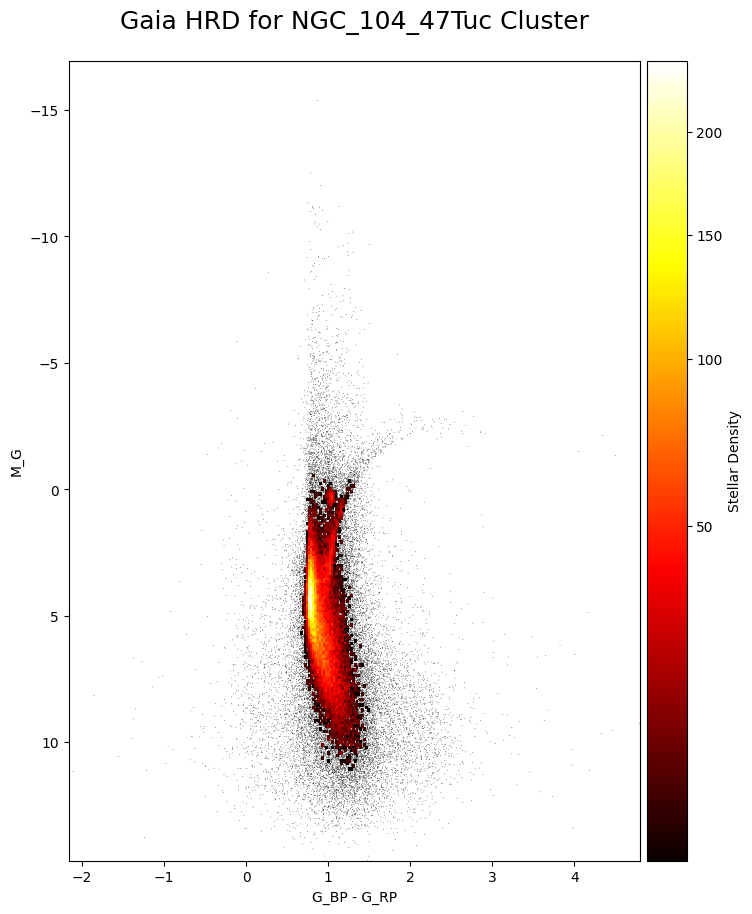

In [102]:
# plot HRD

fig = plt.figure(figsize=(8, 10),dpi=100)
ax = fig.add_axes([.1, .1, .85, .8])
ax.set_title('Gaia HRD for NGC_104_47Tuc Cluster', fontsize=18)
ax.title.set_position([.5, 1.03])
ax.set_xlabel('G_BP - G_RP')
ax.set_ylabel('M_G')
h = ax.hist2d(df['bp_rp'],df['g_abs_104'], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5, cmap ='hot')
ax.scatter(df['bp_rp'],df['g_abs_104'],marker='.',s=[1] * len(df),color = 'k',linewidth=0,zorder=0)
cb = fig.colorbar(h[3], ax=ax, pad=0.01)
cb.set_label("Stellar Density")
ax.invert_yaxis()
# uncomment to save figure
plt.savefig("Hertzsprung-Russell-NGC_104_47Tuc-Cluster.png", dpi=100)

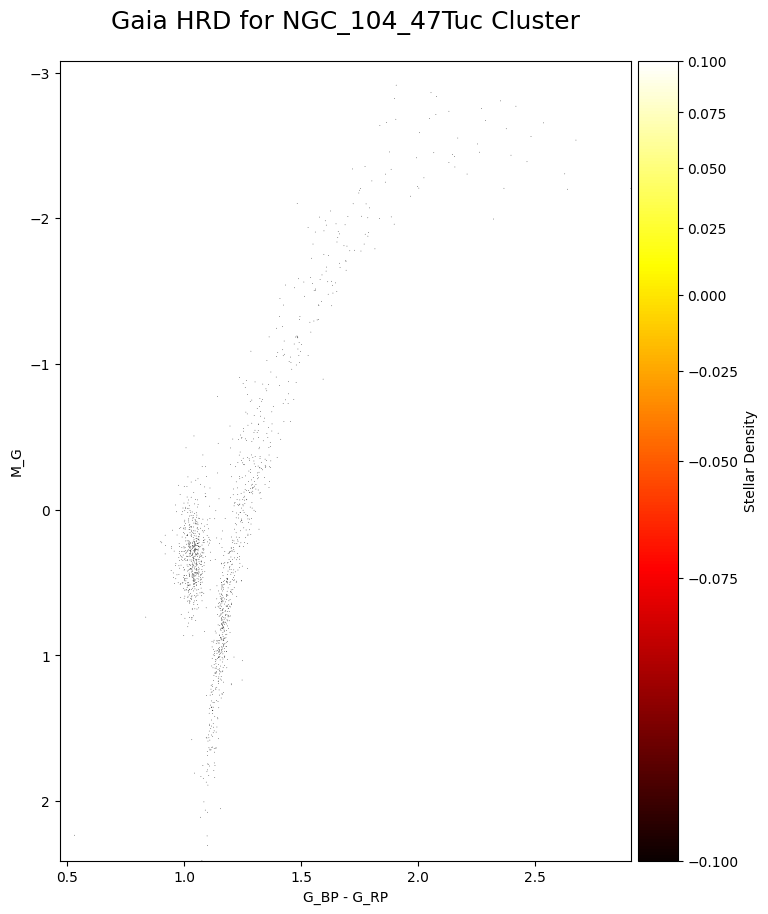

In [91]:
# plot HRD

fig = plt.figure(figsize=(8, 10),dpi=100)
ax = fig.add_axes([.1, .1, .85, .8])
ax.set_title('Gaia HRD for NGC_104_47Tuc Cluster', fontsize=18)
ax.title.set_position([.5, 1.03])
ax.set_xlabel('G_BP - G_RP')
ax.set_ylabel('M_G')
h = ax.hist2d(data_104_dic_mask['bp_rp'],data_104_dic_mask['g_abs_104'], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5, cmap ='hot')
ax.scatter(data_104_dic_mask['bp_rp'],data_104_dic_mask['g_abs_104'],marker='.',s=[1] * len(data_104_dic_mask),color = 'k',linewidth=0,zorder=0)
cb = fig.colorbar(h[3], ax=ax, pad=0.01)
cb.set_label("Stellar Density")
ax.invert_yaxis()
# uncomment to save figure
#plt.savefig("Hertzsprung-Russell-dr3.png", dpi=100)

In [92]:
# Select NGC_7099_M_30 Cluster

data_7099_dic = pd.DataFrame(data_7099_dic)
data_7099_dic

,ra,dec,parallax,parallax_error,parallax_over_error,visibility_periods_used,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,dr2_rv_template_fe_h,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_g_mean_mag,bp_rp,ruwe,astrometric_excess_noise,phot_bp_rp_excess_factor,fiveparam
0,324.898376,-23.261793,0.652736,0.315582,2.068357,19.0,482.997345,52.642815,24.466057,19.922525,18.385586,531.099304,496.0,NaN,5.497844,-5.627593,0.309065,0.250358,0.317946,19.188675,1.536940,1.017725,0.33768,1.250874,True
1,324.900757,-23.252172,0.198326,0.213019,0.931025,19.0,738.973145,73.507256,29.821495,19.159962,18.011303,477.030579,499.0,NaN,-11.211298,-6.011466,0.225884,0.161052,0.258760,18.640919,1.148659,0.962474,0.00000,1.201350,True
2,324.901184,-23.251122,-0.241314,0.293765,-0.821454,19.0,518.159302,40.235306,35.314083,19.371578,18.714304,480.767761,493.0,NaN,-0.814766,-6.902496,0.308428,0.219093,0.258207,19.112816,0.657274,0.968130,0.00000,1.179030,True
3,324.893555,-23.259478,1.536287,0.753166,2.039771,18.0,202.009201,16.937723,13.672977,20.741463,19.794188,456.858185,446.0,NaN,-1.573076,-7.476942,0.732178,0.574534,0.356083,20.284716,0.947275,0.981501,0.00000,1.137518,True
4,324.892212,-23.253036,-0.402210,1.008600,-0.398780,16.0,162.056885,10.106934,9.439791,20.706335,20.137600,407.928070,372.0,NaN,0.389551,-5.801156,1.231766,0.735133,0.134735,20.508085,0.568735,1.031850,0.00000,1.196299,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482,325.198151,-23.022617,0.407057,0.370532,1.098573,16.0,349.505127,9.821050,10.179796,19.851685,19.295776,523.699036,517.0,NaN,-0.388669,-7.288763,0.397935,0.348616,0.409463,19.443083,0.555908,0.985377,0.00000,0.979867,True
8483,325.198212,-23.023510,0.198521,0.050429,3.936619,17.0,3710.499756,641.401672,333.817352,16.278812,15.136454,457.225281,502.0,NaN,-0.506368,-10.857066,0.051924,0.040464,0.337471,15.792218,1.142359,0.938925,0.00000,1.233316,True
8484,325.203583,-23.010502,1.037691,0.443761,2.338400,15.0,392.931122,48.107643,17.735680,20.441730,18.513487,507.404144,513.0,NaN,-2.621569,-7.726732,0.542506,0.388218,0.203458,19.494165,1.928244,0.975907,0.00000,1.341684,False
8485,325.181610,-23.018070,0.106977,0.208964,0.511939,17.0,810.509033,68.553337,47.425129,18.763996,18.127012,499.207977,525.0,NaN,-0.351640,-7.322421,0.216661,0.185508,0.412365,18.517904,0.636984,0.958281,0.00000,1.181489,True


In [93]:
g_abs_7099 = data_7099_dic ['phot_g_mean_mag']+ 5 + 5*np.log10(data_7099_dic['parallax']/1000)
data_7099_dic  = pd.concat([data_7099_dic,g_abs_7099],axis = 1)
data_7099_dic .rename(index=str,columns={0:'g_abs_7099'},inplace=True)
data_7099_dic

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ra,dec,parallax,parallax_error,parallax_over_error,visibility_periods_used,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,dr2_rv_template_fe_h,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_g_mean_mag,bp_rp,ruwe,astrometric_excess_noise,phot_bp_rp_excess_factor,fiveparam,g_abs_7099
0,324.898376,-23.261793,0.652736,0.315582,2.068357,19.0,482.997345,52.642815,24.466057,19.922525,18.385586,531.099304,496.0,NaN,5.497844,-5.627593,0.309065,0.250358,0.317946,19.188675,1.536940,1.017725,0.33768,1.250874,True,8.262363
1,324.900757,-23.252172,0.198326,0.213019,0.931025,19.0,738.973145,73.507256,29.821495,19.159962,18.011303,477.030579,499.0,NaN,-11.211298,-6.011466,0.225884,0.161052,0.258760,18.640919,1.148659,0.962474,0.00000,1.201350,True,5.127813
2,324.901184,-23.251122,-0.241314,0.293765,-0.821454,19.0,518.159302,40.235306,35.314083,19.371578,18.714304,480.767761,493.0,NaN,-0.814766,-6.902496,0.308428,0.219093,0.258207,19.112816,0.657274,0.968130,0.00000,1.179030,True,NaN
3,324.893555,-23.259478,1.536287,0.753166,2.039771,18.0,202.009201,16.937723,13.672977,20.741463,19.794188,456.858185,446.0,NaN,-1.573076,-7.476942,0.732178,0.574534,0.356083,20.284716,0.947275,0.981501,0.00000,1.137518,True,11.217077
4,324.892212,-23.253036,-0.402210,1.008600,-0.398780,16.0,162.056885,10.106934,9.439791,20.706335,20.137600,407.928070,372.0,NaN,0.389551,-5.801156,1.231766,0.735133,0.134735,20.508085,0.568735,1.031850,0.00000,1.196299,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482,325.198151,-23.022617,0.407057,0.370532,1.098573,16.0,349.505127,9.821050,10.179796,19.851685,19.295776,523.699036,517.0,NaN,-0.388669,-7.288763,0.397935,0.348616,0.409463,19.443083,0.555908,0.985377,0.00000,0.979867,True,7.491358
8483,325.198212,-23.023510,0.198521,0.050429,3.936619,17.0,3710.499756,641.401672,333.817352,16.278812,15.136454,457.225281,502.0,NaN,-0.506368,-10.857066,0.051924,0.040464,0.337471,15.792218,1.142359,0.938925,0.00000,1.233316,True,2.281252
8484,325.203583,-23.010502,1.037691,0.443761,2.338400,15.0,392.931122,48.107643,17.735680,20.441730,18.513487,507.404144,513.0,NaN,-2.621569,-7.726732,0.542506,0.388218,0.203458,19.494165,1.928244,0.975907,0.00000,1.341684,False,9.574507
8485,325.181610,-23.018070,0.106977,0.208964,0.511939,17.0,810.509033,68.553337,47.425129,18.763996,18.127012,499.207977,525.0,NaN,-0.351640,-7.322421,0.216661,0.185508,0.412365,18.517904,0.636984,0.958281,0.00000,1.181489,True,3.664358


In [96]:
df1 = data_7099_dic.drop('dr2_rv_template_fe_h', 1)
df1 = df1.dropna()
df1

,ra,dec,parallax,parallax_error,parallax_over_error,visibility_periods_used,phot_g_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_mag,astrometric_chi2_al,astrometric_n_good_obs_al,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_g_mean_mag,bp_rp,ruwe,astrometric_excess_noise,phot_bp_rp_excess_factor,fiveparam,g_abs_7099
0,324.898376,-23.261793,0.652736,0.315582,2.068357,19.0,482.997345,52.642815,24.466057,19.922525,18.385586,531.099304,496.0,5.497844,-5.627593,0.309065,0.250358,0.317946,19.188675,1.536940,1.017725,0.33768,1.250874,True,8.262363
1,324.900757,-23.252172,0.198326,0.213019,0.931025,19.0,738.973145,73.507256,29.821495,19.159962,18.011303,477.030579,499.0,-11.211298,-6.011466,0.225884,0.161052,0.258760,18.640919,1.148659,0.962474,0.00000,1.201350,True,5.127813
3,324.893555,-23.259478,1.536287,0.753166,2.039771,18.0,202.009201,16.937723,13.672977,20.741463,19.794188,456.858185,446.0,-1.573076,-7.476942,0.732178,0.574534,0.356083,20.284716,0.947275,0.981501,0.00000,1.137518,True,11.217077
8,324.919739,-23.232649,0.540048,0.258359,2.090301,18.0,631.604248,44.342136,35.019604,19.030838,18.445137,506.745087,507.0,-1.029353,-7.514722,0.277760,0.219525,0.415649,18.831570,0.585701,0.981197,0.00000,1.204495,True,7.493729
10,324.905853,-23.221300,0.231408,0.416536,0.555553,18.0,365.550476,23.696283,21.526974,19.957012,19.192539,474.265442,511.0,-0.566994,-6.778235,0.463511,0.317870,0.240320,19.620007,0.764473,0.942314,0.00000,1.155722,True,6.441895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482,325.198151,-23.022617,0.407057,0.370532,1.098573,16.0,349.505127,9.821050,10.179796,19.851685,19.295776,523.699036,517.0,-0.388669,-7.288763,0.397935,0.348616,0.409463,19.443083,0.555908,0.985377,0.00000,0.979867,True,7.491358
8483,325.198212,-23.023510,0.198521,0.050429,3.936619,17.0,3710.499756,641.401672,333.817352,16.278812,15.136454,457.225281,502.0,-0.506368,-10.857066,0.051924,0.040464,0.337471,15.792218,1.142359,0.938925,0.00000,1.233316,True,2.281252
8484,325.203583,-23.010502,1.037691,0.443761,2.338400,15.0,392.931122,48.107643,17.735680,20.441730,18.513487,507.404144,513.0,-2.621569,-7.726732,0.542506,0.388218,0.203458,19.494165,1.928244,0.975907,0.00000,1.341684,False,9.574507
8485,325.181610,-23.018070,0.106977,0.208964,0.511939,17.0,810.509033,68.553337,47.425129,18.763996,18.127012,499.207977,525.0,-0.351640,-7.322421,0.216661,0.185508,0.412365,18.517904,0.636984,0.958281,0.00000,1.181489,True,3.664358


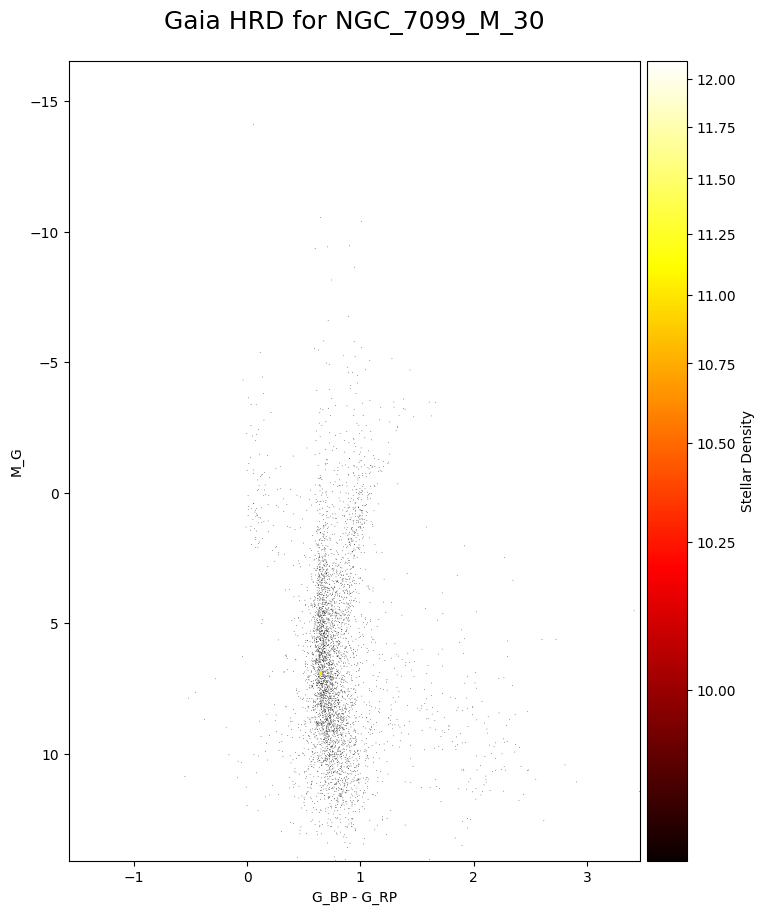

In [99]:
# plot HRD

fig = plt.figure(figsize=(8, 10),dpi=100)
ax = fig.add_axes([.1, .1, .85, .8])
ax.set_title('Gaia HRD for NGC_7099_M_30', fontsize=18)
ax.title.set_position([.5, 1.03])
ax.set_xlabel('G_BP - G_RP')
ax.set_ylabel('M_G')
h = ax.hist2d(df1['bp_rp'],df1['g_abs_7099'], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5, cmap ='hot')
ax.scatter(df1['bp_rp'],df1['g_abs_7099'],marker='.',s=[1] * len(df1),color = 'k',linewidth=0,zorder=0)
cb = fig.colorbar(h[3], ax=ax, pad=0.01)
cb.set_label("Stellar Density")
ax.invert_yaxis()
# uncomment to save figure
#plt.savefig("Hertzsprung-Russell-dr3.png", dpi=100)